# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment to train agents in a continuous action space.

### 1. Start the Environment


We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Determine if GPU can be used

In [5]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 4. Define the Actor network

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        #self.gru_hidden_dim = 100
        self.hidden_dim_0 = 250
        self.hidden_dim = 150
        
        #self.gru = nn.GRU(input_size=state_size, hidden_size=self.gru_hidden_dim, batch_first=True)
        self.lin0 = nn.Linear(state_size, self.hidden_dim_0)
        self.lin1 = nn.Linear(self.hidden_dim_0, self.hidden_dim)
        self.dropout = nn.Dropout(p=0.2)
        self.lin2 = nn.Linear(self.hidden_dim, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        #x = F.relu(self.gru(input=state)[0])
        #x = x[:, -1, :] # keep only last entry of sequence dim
        x = F.relu(self.lin0(state))
        x = self.dropout(x)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.lin2(x)
        return F.tanh(x)

### 5. Define the Critic network

In [7]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        #self.gru_hidden_dim = 100
        self.hidden_dim_0 = 250
        self.hidden_dim = 150
        
        #self.gru = nn.GRU(input_size=state_size, hidden_size=self.gru_hidden_dim, batch_first=True)
        self.lin0 = nn.Linear(state_size, self.hidden_dim_0)
        self.lin1 = nn.Linear(self.hidden_dim_0 + action_size, self.hidden_dim)
        self.dropout = nn.Dropout(p=0.2)
        self.lin2 = nn.Linear(self.hidden_dim, 1)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        #x = F.relu(self.gru(input=state)[0])
        #x = x[:, -1, :] # keep only last entry of sequence dim
        x = F.relu(self.lin0(state))
        x = self.dropout(x)
        x = torch.cat((x, action), dim=1)
        #continuous action space
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        return self.lin2(x)

### 6. Define some hyper parameters
In the following cell we define hyper parmeters and constants for the learning algorithm.

In [8]:
n_episodes = 1000
replay_buffer_size = 100000
batch_size = 128
gamma = 0.99
learning_rate = 0.0001
tau = 0.001

target_score = 30.0
seed = 42

### 7. Noise for exploration
A simple helper class to generate noise based on the Ornstein-Uhlenbeck process.
This is used to explore the action space.

In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = np.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

### 8. The replay buffer
A simple helper class for storing experience tuples and randomly draw samples from them.

In [3]:
from collections import namedtuple, deque

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)#add to experience e to replay buffer
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)#take Batch size number of random elements(that can be arrays, here SARS tuples) from the replay buffer

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 9. Define the Agents

In [10]:
from collections import deque
import random 

class Agents():
    """Interact with and learns from the environment."""
    
    def __init__(self, n_agents, state_size, action_size, random_seed):  
        """Initialize an Agents object.
        
        Params
        ======
            n_agents (int): the number of agents
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
       
        self.n_agents = n_agents
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=learning_rate)

        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=learning_rate) 

        self.noise = OUNoise((n_agents, action_size), random_seed) 
        self.memory = ReplayBuffer(action_size, replay_buffer_size, batch_size, random_seed)
    
    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device) 
        self.actor_local.eval()

        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()            
            
        self.actor_local.train()
        action += self.noise.sample() # add noise to explore action space
        return np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()
    
    def step(self, state, action, reward, next_state, done):
        # store all agents' experience tuples
        for i in range(self.n_agents):
            self.memory.add(state[i], action[i], reward[i], next_state[i], done[i])
            
        # if there are enough tuples, get a sample and learn from it
        if len(self.memory) >= batch_size:
            samples = self.memory.sample()
            self.learn(*samples)

    def learn(self, states, actions, rewards, next_states, dones):

        next_actions = self.actor_target(next_states) # predict actions
        next_targets = self.critic_target(next_states, next_actions) # predict max Q values for next state    
        targets = rewards + (gamma * next_targets * (1 - dones)) # Q values for current state
               
        # Compute critic loss
        expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(expected, targets)
        
        # critic step
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean() 

        # actor step
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # update target networks
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)                  

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to) 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


### 10. The Algorithm (DDPG)

In [ ]:
scores = []
scores_window = deque(maxlen=100)
solved = False

env_info = env.reset(train_mode=True)[brain_name]
n_agents = len(env_info.agents)
agents = Agents(n_agents, state_size, action_size, seed)

for episode in range(1, 1 + n_episodes):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations
    
    agents.reset()
    score = np.zeros(n_agents)
    done = [False]
    while not np.any(done):
        action = agents.act(state) # choose best action according to current policy
        env_info = env.step(action)[brain_name] # apply action in environment
        
        # get reward and next state from environment
        next_state = env_info.vector_observations
        reward = env_info.rewards
        done = env_info.local_done
        
        # make the agents learn
        agents.step(state, action, reward, next_state, done)
        
        score += reward
        state = next_state

    scores.append(np.mean(score))
    scores_window.append(np.mean(score))
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    
    avg_score = np.mean(scores_window)
    if avg_score > target_score:
        torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
        np.save('scores30.npy', np.array(scores))
        if episode > 100 and not solved:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))

    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
    if episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        
env.close()

Episode 100	Average Score: 10.14
Episode 165	Average Score: 29.97
Environment solved in 166 episodes!	Average Score: 30.24
Episode 200	Average Score: 32.57
Episode 210	Average Score: 32.61

### 11. Plot the score history

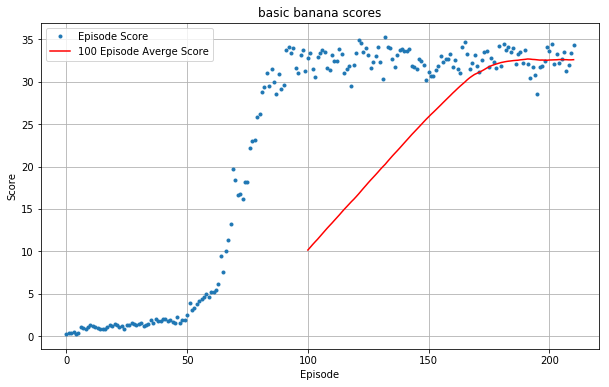

In [2]:
import matplotlib.pyplot as plt
import numpy as np

scores = np.load('scores30.npy')

means = []
for i in range(100, len(scores)):
    means.append([i, np.mean(scores[i-100:i])])
means = np.array(means)
plt.figure(figsize=(10, 6))
plt.plot(scores ,'.')
plt.plot(means[:, 0],means[:, 1],'r')
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('basic banana scores')
plt.legend(['Episode Score', '100 Episode Averge Score'])